# Testing the helicity from obs calculation

In [56]:
import os, sys
sys.path.append('../')

from shell import ShellModel, FieldTransformer
import shell.observable as obs
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import imagine as img
import shell.visualization as visu


We will use a common grid for all the calculations

In [57]:
L = 70*u.pc; N = 200

grid = img.UniformGrid(# coordinate values for edges of the grid box
                       box=[[-L,L],[-L,L],[-L,L]], 
                       # Grid resolution
                       resolution=[N, N, N])

The naive random field previously defined in notebook 4 is copied here, with some adjustments

Now, I will define a helper class which contains the full specficiation of the model and stores the relevant quantities during one particular evaluation. This is done in a very inefficient fashion, as clarity is the main goal.

In [58]:
import shell.fields as fields
from collections import defaultdict
import astropy.constants as c
muG = u.microgauss

class Model:
    """
    Helper class to make it easier to construct the model library
    """
    def __init__(self, grid, shell_parameters={}, ne=1*u.cm**-3, 
                 B_Brnd=1, B=[0*muG, 0*muG, 0*muG], ncr_ne=1, 
                 shell_a=None, shell_b=None, #for convenience                 
                 cr_type='thermal', B_type='uniform', period=70*u.pc,
                 freqs=[1.4*u.GHz, 2.7*u.GHz], #, 4.8*u.GHz, 10*u.GHz],
                 gamma=1):
        
            # Creates the shell model
            shell_dict = dict(V0=0.0153*u.pc/u.yr,
                              a=1.3, b=10, R=50*u.pc,
                              elapsed_time=1300*u.yr)
            shell_dict.update(shell_parameters)
            if shell_a is not None:
                shell_dict['a'] = shell_a
            if shell_b is not None:
                shell_dict['b'] = shell_b
            shell_model = ShellModel(**shell_dict)
        
            # Generates the field transformer
            field_transformer = FieldTransformer(grid, shell_model)
            
            # Initial density model
            n0 = ne*np.ones(grid.shape)
            
            # Initial large scale field model
            if B_type == 'uniform':
                Bls = [Bi*np.ones(grid.shape) for Bi in B]
            elif B_type == 'helical':
                Bls = fields.helical(grid, B) 
            
            # Initial random field model
            Brms = np.sqrt(np.mean(Bls[0]**2+Bls[1]**2+Bls[2]**2)) / B_Brnd
            Brnd = fields.simple_random(grid, Brms)
            
            # Total initial field
            B0 = [Bls_i + Brnd_i for Bls_i, Brnd_i in zip(Bls, Brnd)]
            
            # Computes final B and thermal electron density
            self.ne, self.B = field_transformer(n0, B0)
            # Convenience unpacking
            self.Bx, self.By, self.Bz = self.B
            # Cosmic ray model
            if cr_type == 'uniform':
                # Uniformly distributed cosmic rays
                self.ncr = ne*np.ones(grid.shape)*ncr_ne
            elif cr_type == 'thermal':
                # Cosmic ray density proportional to thermal electron density
                self.ncr = self.ne*ncr_ne
            else:
                raise ValueError('Available options: "thermal" or "uniform"')
        
            # Stores frequencies (converted to wavelenghts), grid, etc
            self.wavelengths = [(c.c/(f)).to(u.cm) for f in freqs]
            self.grid = grid
            self.gamma = gamma
            self._stokes = None
            self._Psi = None
            self._RM = None
            self._PI = None
     
    @property
    def Q(self):
        if self._stokes is None:
            self._compute_stokes()
        return self._stokes['Q']
    @property
    def U(self):
        if self._stokes is None:
            self._compute_stokes()
        return self._stokes['U']
    @property
    def I(self):
        if self._stokes is None:
            self._compute_stokes()
        return self._stokes['I']
    
    @property
    def Psi(self):
        if self._Psi is None:
            self._Psi = []
            for U, Q in zip(self.U, self.Q):
                # Computes Psi for all requested wavelengths
                self._Psi.append(obs.compute_Psi(U,Q))
        return self._Psi
    
    @property
    def PI(self):
        if self._PI is None:
            self._PI = []
            for U, Q in zip(self.U, self.Q):
                # Computes Psi for all requested wavelengths
                self._PI.append(np.sqrt(U**2+Q**2))
        return self._PI
    
    @property
    def RM(self):
        if self._RM is None:
            self._RM = []
            for Psi1, lambda1, Psi2, lambda2 in zip(self.Psi[:-1],
                                                    self.wavelengths[:-1],
                                                    self.Psi[1:],
                                                    self.wavelengths[1:]):
                RM = obs.compute_RM(Psi1, Psi2, lambda1, lambda2)
                self._RM.append(RM.to(u.rad/u.m/u.m))
        return self._RM
    
    def _compute_stokes(self):
        self._stokes = defaultdict(list)
        for wavelength in self.wavelengths:
            I, Q, U = obs.compute_stokes_parameters(self.grid, wavelength, 
                                                    self.Bx, self.By, self.Bz,
                                                    self.ne, self.ncr, 
                                                    self.gamma)
            self._stokes['I'].append(I)
            self._stokes['Q'].append(Q)
            self._stokes['U'].append(U)

Observables (e.g. Q) appear in lists (one item per input frequency) while physical quantities (e.g. Bx) not. 
Note that the RM property is computed combining 2 consecutive wavelengths. Thus , it contains less elements than, say, stokes Q. 

Let us test this

In [85]:
freqs = [(c.c/(3*u.cm)).to(u.GHz), (c.c/(6*u.cm)).to(u.GHz)]
freqs

[<Quantity 9.99308193 GHz>, <Quantity 4.99654097 GHz>]

In [86]:
uniform_model = Model(grid, B=[1,0, 0]*muG,B_type='uniform', 
                      freqs=freqs)
helical_model = Model(grid, B=[1,0, 0]*muG,B_type='helical', 
                      freqs=freqs)

## Parameters grid

In [87]:
import shell.helicity as hel

(200,)
(200,)


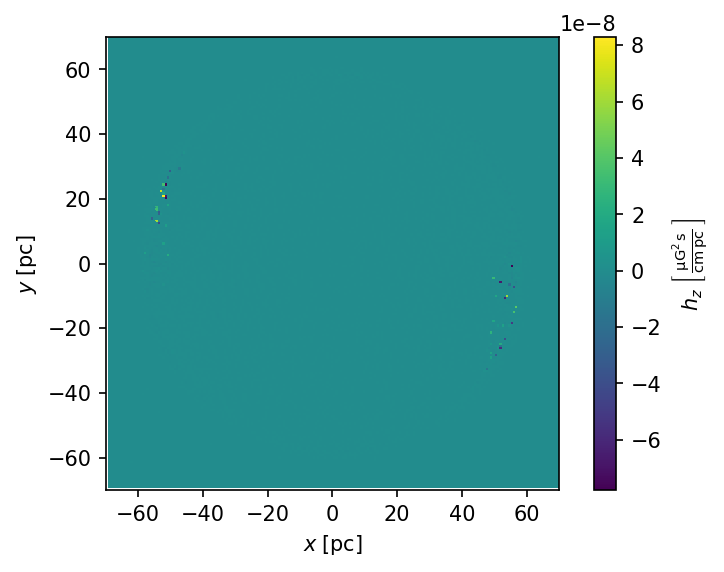

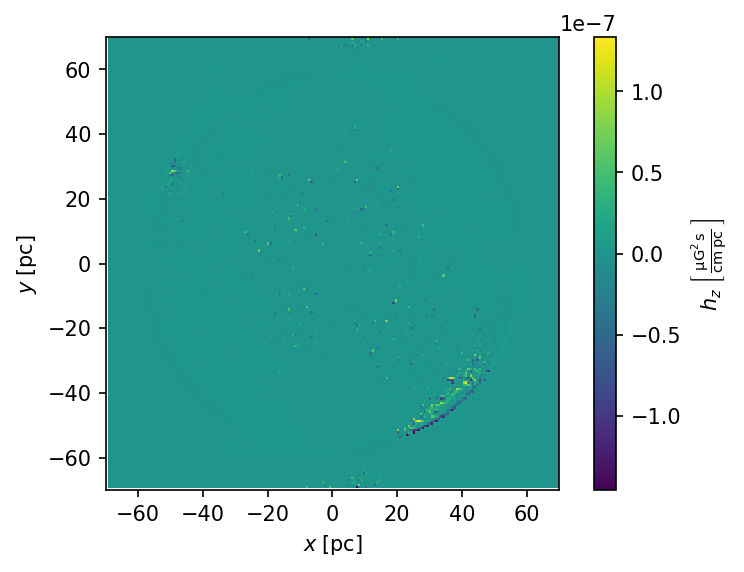

In [89]:
from importlib import reload
import shell
reload(shell.helicity)
reload(shell.visualization)

for model in (uniform_model, helical_model):
    # Radius of the remnant/box
    Lz = (model.grid.box[2][1]-model.grid.box[2][0])/2
    
    ncr_mean = np.mean(model.ncr, axis=2)
    ne_mean = np.mean(model.ne, axis=2)
    
    Hz, Jz = hel.average_helicity(RM=model.RM[0], I=model.I, PA=model.Psi,
                                  wavelengths=model.wavelengths,
                              ne=1*u.cm**-3, ncr=1*u.cm**-3, L=Lz,
                              x=model.grid.x[:,0,0], y=model.grid.y[0,:,0],
                              boundary_radius=1, output_current=True)
    visu.plot_scalar_xy(grid, Hz, name='h_z');